In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from stompy.grid import unstructured_grid
import stompy.model.delft.dflow_model as dfm
from shapely import geometry
from stompy.plot import plot_wkb

%matplotlib notebook

In [22]:
# Sophie's run:
#run_dir="/media/cws/hydro/Pescadero/Model_Runs/Testing/run_tide_test-v107"
#his_fn=run_dir+"/DFM_OUTPUT_flowfm/flowfm_his.nc"

# My run that is maybe similar:
run_dir="data_mouth_v032"
his_fn=run_dir+"/DFM_OUTPUT_flowfm/flowfm_0000_his.nc"
model=dfm.DFlowModel.load(run_dir)

In [23]:
try:
    his_ds.close()
except NameError:
    pass
his_ds=xr.open_dataset(his_fn)

In [24]:
tran=dfm.extract_transect_his(his_ds,'thalweg_pesc_.*')

<IPython.core.display.Javascript object>


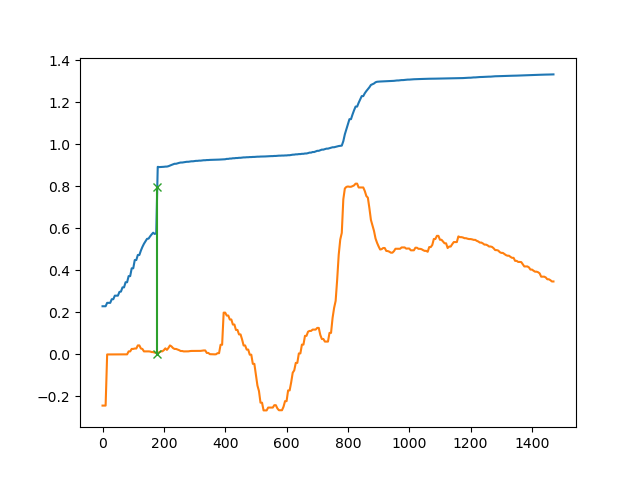

Requested time: 2016-12-13T01:00
Actual time:    2016-12-13T01:00:00.000000000


In [25]:
plt.figure()

t=np.datetime64("2016-12-13 01:00")

plt.plot( tran.d_sample, tran.waterlevel.sel(time=t,method='nearest'),
         label='water')
plt.plot( tran.d_sample, tran.bedlevel,label='bed')


# Can I draw in crest level, too?
struct=model.structures[3]
crest_level=struct['CrestLevel'].val1
geo_tran=geometry.LineString(np.c_[ tran.x_sample, tran.y_sample])
geo_strt=geometry.LineString(struct['geom'])
d=geo_tran.project(geo_tran.intersection(geo_strt))
plt.plot([d,d],[0,crest_level.sel(time=t,method='nearest')],
        marker='x')

t_actual=tran.time.sel(time=t,method='nearest').values
print("Requested time:",t)
print("Actual time:   ",t_actual)

In [ ]:
model.structures[3]

In [ ]:
#map_ds=xr.open_dataset(run_dir+"/DFM_OUTPUT_flowfm/flowfm_map.nc")
#grid=unstructured_grid.UnstructuredGrid.read_ugrid(map_ds)

In [ ]:
# Find reasonable structure to look at:
fig=plt.figure()
grid.plot_edges(color='k',lw=0.4)
ccoll=grid.plot_cells(values=grid.cells['mesh2d_flowelem_bl'],cmap='turbo',clim=[0,2])
plt.axis('tight')
plt.axis('equal')
plt.axis('off')

for i,struct in enumerate(model.structures):
    ls=struct['geom']
    lines=plt.plot(ls[:,0],ls[:,1])
    plt.text( ls[0,0],ls[0,1],f"[{i}]: {struct['id']}",
             color=lines[0].get_color())

fig.tight_layout()
plt.axis((551992.9099230398, 552207.381984984, 4124583.192877078, 4124741.4099719548))
cax=fig.add_axes([0.87,0.4,0.02,0.5])
plt.colorbar(ccoll,cax=cax)

In [ ]:
# 3: mouth and 4: mouth_B are the ones to look at.
# They are the only general_structures in the history file
gs_i=1

gs_vars=[v for v in his_ds.variables if 'general_structures' in his_ds[v].dims]
gs_vars

# crest_level, s1up,s1dn, head, flow_area, velocity
# How to get a Froude number?
# crest_width I think is in the flow direction

In [ ]:
his_ds

In [ ]:
fig,axs=plt.subplots(3,1,sharex=True)
# For structure 0, this theory doesn't hold. Does look like
# flow was critical over structure 0 for a brief moment right
# when the system started to open. Fr=0.82 is what shows up,
# but they behavior looks like critical flow over a weir.
# Froude number is mostly around 0.2 after that.
# For structure 1 (ocean side), also doesn't hold. A short
# period at the start of breach suggests critical flow with
# estimate Fr=0.53 or so.
# Most telling is that right around this flow feature where the
# velocity rises a bit right when the tide is coming back in
# corresponds to the downstream water level actually dipping
# a bit. 

gs=his_ds.isel(general_structures=0)

axs[0].plot(gs.time, gs['general_structure_crest_level'], label='Crest level')
axs[0].plot(gs.time, gs['general_structure_s1up'], label='s1up')
axs[0].plot(gs.time, gs['general_structure_s1dn'], label='s1dn')
# axs[0].plot(gs.time, gs['general_structure_head'], label='head')
axs[1].plot(gs.time, gs['general_structure_velocity'],label='velocity')

# Trying to come up with the same sort of values as dfm
vel_upstream=gs['general_structure_velocity'] # clearly wrong..
vel_hght=vel_upstream**2/(2*9.8)
elu=gs['general_structure_s1dn']+vel_hght
d_crit=elu-gs['general_structure_crest_level']
ds_min=gs['general_structure_s1up']-gs['general_structure_crest_level']

axs[2].plot(gs.time,d_crit,label='d_crit')
axs[2].plot(gs.time,ds_min,label='ds from s1up')

h=np.maximum(gs['general_structure_s1up'],gs['general_structure_s1dn']) - gs['general_structure_crest_level']
Fr=np.abs(gs['general_structure_velocity']) / np.sqrt(9.8*h)
axs[1].plot(gs.time,Fr,label='Fr')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
axs[0].axis((17147.711364063103, 17148.740337798197, 0.5193483301551929, 2.3215709276583665))

In [ ]:
axs[0].axvline(np.datetime64("2016-12-13 01:00"))